In [1]:
# Reload package
import importlib
import src.utils.config_loader
importlib.reload(src.utils.config_loader)

from src.utils.config_loader import ConfigLoader

config_loader = ConfigLoader()
all_configs = config_loader.load_configs()

base_configs = config_loader.get_section(all_configs, "base")
graph_configs = config_loader.get_section(all_configs, "graph")

In [2]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")   # type: ignore

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA version: 12.8


In [3]:
# Preprocess data
import importlib
import src.modules.data_processor
importlib.reload(src.modules.data_processor)

from src.modules.data_processor import DataProcessor
data_processor = DataProcessor(base_configs=base_configs)
processed_data = data_processor.run(device=device, summarize=False)

Processed files already exist, loading ['comments.pkl', 'replies.pkl', 'user_pairs.pkl', 'submissions.pkl'] from 'data/processed/'


In [4]:
import importlib
import src.modules.graph_processor
importlib.reload(src.modules.graph_processor)

from src.modules.graph_processor import GraphProcessor

processed_path = base_configs.get('processed_path', 'data/processed')
graph_processor = GraphProcessor(graph_configs=graph_configs, processed_path=processed_path)

pairs = processed_data.user_pairs
comments = processed_data.comments
graph_data = graph_processor.run(pairs=pairs, embeddings_source=comments)

Building node features with pooling: mean
    + Total unique authors in pairs: 35257
    + Total pooled vectors: 35212
    + Pooled vector dimension: 384
Building graph snapshots: directed=True, use_wcc=True, edge_attrs=['mean_confidence', 'net_vector']
    + [Subreddit 0, T0] 2 edges filtered by WCC (86 -> 84)
    + [Subreddit 0, T7] 1 edges filtered by WCC (177 -> 176)
    + [Subreddit 0, T11] 1 edges filtered by WCC (944 -> 943)
    + [Subreddit 0, T13] 4 edges filtered by WCC (701 -> 697)
    + [Subreddit 0, T15] 1 edges filtered by WCC (1195 -> 1194)
    + [Subreddit 0, T16] 2 edges filtered by WCC (608 -> 606)
    + [Subreddit 0, T18] 1 edges filtered by WCC (948 -> 947)
    + [Subreddit 0, T19] 1 edges filtered by WCC (893 -> 892)
    + [Subreddit 0, T21] 2 edges filtered by WCC (544 -> 542)
    + [Subreddit 0, T22] 4 edges filtered by WCC (421 -> 417)
    + [Subreddit 1, T0] 456 edges filtered by WCC (599 -> 143)
    + [Subreddit 1, T1] 281 edges filtered by WCC (323 -> 42)
   

c:\Users\vduch\OneDrive\ecs_msc_project\src\modules\graph_processor.py:145: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  x = torch.tensor(node_features, dtype=torch.float)


    + Created 77 PyG graphs
Saved PyG graphs to data/processed/pyg_graphs_384D.pt


In [21]:
import importlib
import src.models.multitask_debate_gnn
importlib.reload(src.models.multitask_debate_gnn)

from src.models.multitask_debate_gnn import ECCConv, MultitaskDebateGNN, train_gnn_live, plot_cv_losses
from torch_geometric.nn import GCNConv, SAGEConv

MODEL_ARGS = dict(
    in_dim = 384,
    hidden_dim = 256,
    emb_dim = 128,
    mode = "link_only",
    neg_attr_weight = 0.3,
    dropout = 0.1,
    num_layers = 3,
    conv_cls  = SAGEConv,
)
TRAIN_ARGS = dict(
    epochs = 10,
    lr = 0.001,
    patience = 20,
    min_delta = 1e-4,
    neg_sample_ratio = 0.6,
    temp_reg_weight = 0.1,
)

try:
    model = MultitaskDebateGNN(**MODEL_ARGS)
    print("Model created:")
    print(f"   Architecture: {[type(conv).__name__ for conv in model.convs]}")
    print(f"   Mode: {model.mode}")
    print(f"   Input dim: {MODEL_ARGS['in_dim']}")
    print(f"   Hidden dim: {MODEL_ARGS['hidden_dim']}")
    print(f"   Embedding dim: {MODEL_ARGS['emb_dim']}")
    print(f"   Number of layers: {MODEL_ARGS['num_layers']}")
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nModel Statistics:")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    print(f"   Model size: ~{total_params * 4 / 1024**2:.1f} MB")
    
    # Show model structure
    print(f"\nModel Structure:")
    print(model)

except Exception as e:
    print(f"Error creating model: {e}")
    import traceback
    traceback.print_exc()

Model created:
   Architecture: ['SAGEConv', 'SAGEConv', 'SAGEConv']
   Mode: link_only
   Input dim: 384
   Hidden dim: 256
   Embedding dim: 128
   Number of layers: 3

Model Statistics:
   Total parameters: 477,442
   Trainable parameters: 477,442
   Model size: ~1.8 MB

Model Structure:
MultitaskDebateGNN(
  (convs): ModuleList(
    (0): SAGEConv(384, 256, aggr=mean)
    (1): SAGEConv(256, 256, aggr=mean)
    (2): SAGEConv(256, 128, aggr=mean)
  )
  (norms): ModuleList(
    (0-1): 2 x LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (activation): GELU(approximate='none')
  (dropout): Dropout(p=0.1, inplace=False)
  (skip): Linear(in_features=384, out_features=128, bias=True)
  (link_head): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)


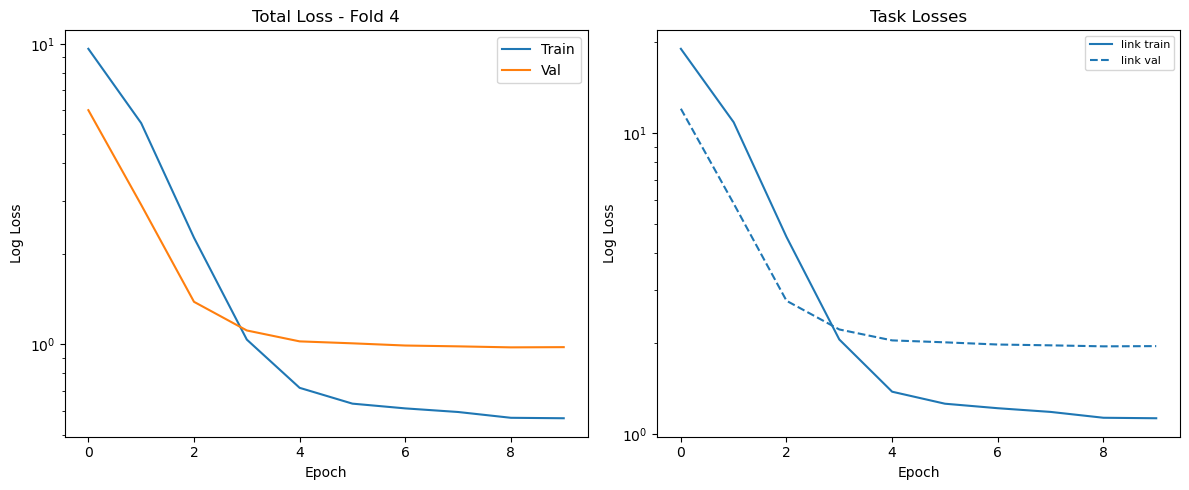


Final Evaluation on Test Subreddit 4:

Test Metrics for 4:
   - Link Auc: 0.8498

*** Per-Fold Results ***
  Subreddit 0:
     - Link Auc          : 0.6856
  Subreddit 1:
     - Link Auc          : 0.9382
  Subreddit 2:
     - Link Auc          : 0.8038
  Subreddit 3:
     - Link Auc          : 0.8403
  Subreddit 4:
     - Link Auc          : 0.8498

*** Average Test Performance ***
  - Link Auc: 0.8235    : 0.8235


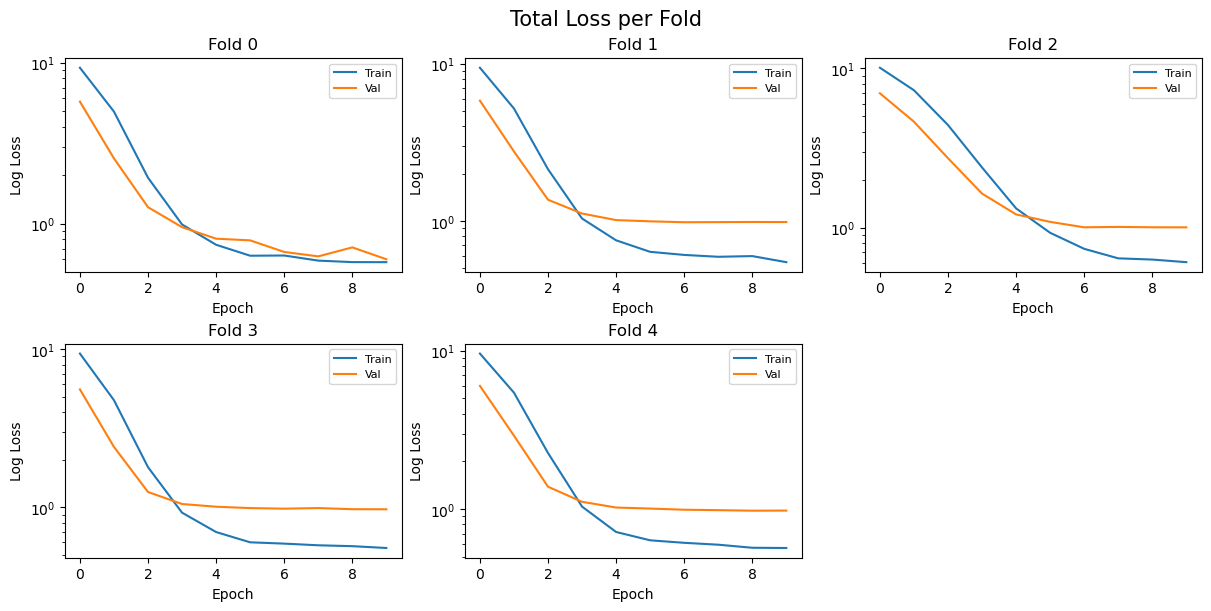

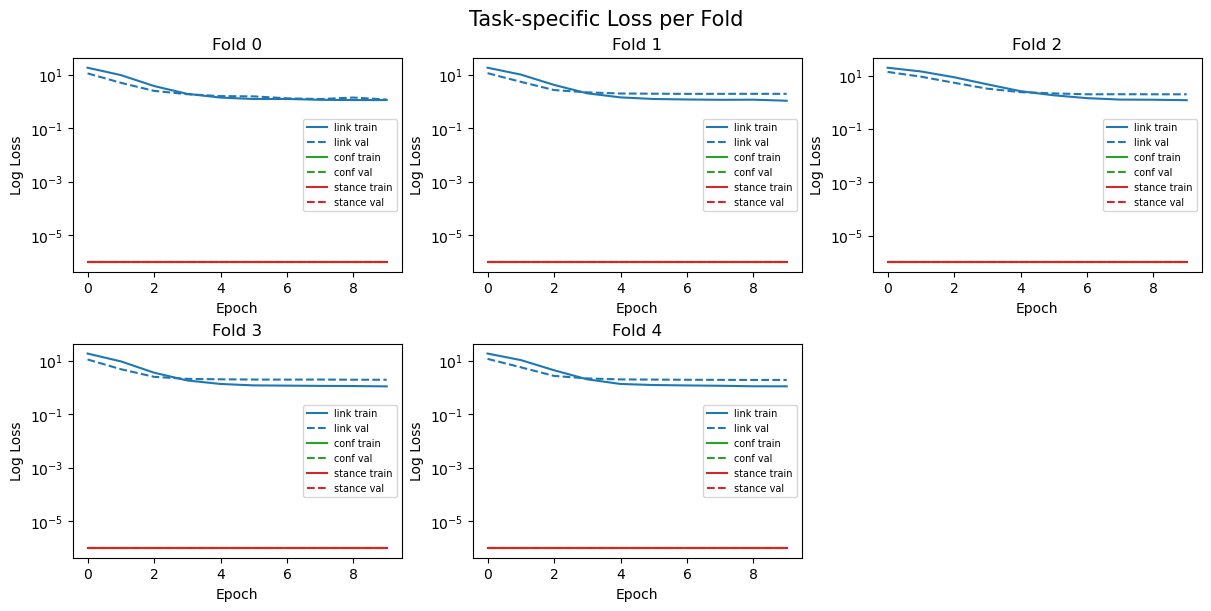

In [19]:
import gc
gc.collect()
torch.cuda.empty_cache()
try:
    # Start cross-validation training
    model_gcn, results_gcn, cv_history_gcn = train_gnn_live(
        all_graphs=graph_data.pyg_graphs,
        model_args=MODEL_ARGS,
        train_args=TRAIN_ARGS,
        model_class=MultitaskDebateGNN,
        live_plot=True,
    )
    plot_cv_losses(cv_history=cv_history_gcn)
    
except Exception as e:
    print(f"Training error: {e}")
    import traceback
    traceback.print_exc()

In [ ]:
#   - Link Auc: 0.7032    : 0.7032  GCN
#   - Link Auc: 0.8235    : 0.8235  SAGE